In [ ]:
#map TFs binding a promoter to their relevant coefficient of variation - see if they correspond to constitutive or variable
#this script will work for any promoter length

In [1]:
import pandas as pd
#import argparse
import os
import seaborn as sns
import matplotlib.pyplot as plt
#stats
from pingouin import kruskal
import scikit_posthocs as sp
from scipy import stats


/home/witham/opt/anaconda3/envs/PromoterArchitecturePipeline/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.7, the latest is 0.3.8.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
# parser = argparse.ArgumentParser(description='map_TF2CV')
# parser.add_argument('file_names', type=str, help='Name of folder and filenames for the promoters extracted')
# parser.add_argument('Czechowski_gene_categories', type=str, help='Input location of Czechowski gene categories text file')
# parser.add_argument('Czechowski_all_cvs', type=str, help='Input location of Czechowski coefficient of variations for all genes in the microarray')
# parser.add_argument('mapped_motif_bed', type=str, help='Input location of promoters mapped motif bed')
# parser.add_argument('output_folder_name', type=str, help='Optional output folder name ending in a forward slash',default = '')

In [3]:
dependent_variable = 'TFBS_TF_class'
file_names = 'non-overlapping_includingbidirectional_all_genes_newannotation'
Czechowski_gene_categories = f'../../data/output/{file_names}/genes/promoters_5UTR_czechowski_constitutive_variable_random.txt'
Czechowski_rankedcv = f'../../data/genes/AtGE_dev_gcRMA__all_probes__CV.tsv'
mapped_motif_bed = f'../../data/output/{file_names}/FIMO/promoters_5UTR_motifs_mapped.bed'
output_folder_name = 'promoters_5UTR/'

In [4]:
#make directory for the plots to be exported to
dirName = f'../../data/output/{file_names}/{dependent_variable}'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " created") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  ../../data/output/non-overlapping_includingbidirectional_all_genes_newannotation/TFBS_TF_class  already exists


In [5]:
#make directory for the plots to be exported to
dirName = f'../../data/output/{file_names}/{dependent_variable}/{output_folder_name}'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " created") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  ../../data/output/non-overlapping_includingbidirectional_all_genes_newannotation/TFBS_TF_class/promoters_5UTR/  already exists


In [6]:
#make directory for the plots to be exported to
dirName = f'../../data/output/{file_names}/{dependent_variable}/{output_folder_name}plots'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " created") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  ../../data/output/non-overlapping_includingbidirectional_all_genes_newannotation/TFBS_TF_class/promoters_5UTR/plots  already exists


In [7]:
def map_cv(ranked_cvs_file,mapped_motifs_file):
    """function to map the CV value to the TFs which bind to each promoter"""
    #read in files
    cvs = pd.read_table(ranked_cvs_file, sep='\t', header=None)
    cols = ['rank','probe_id','TF_AGI','expression_mean','expression_SD','expression_CV','proportion_of_values_present_in_mas5','presence_in_araport11','constitutive_in_araport11']
    cvs.columns = cols
    #filter out any genes that aren't present in araport11
    cvs = cvs[cvs.presence_in_araport11==1]
    #read in mapped motifs
    mapped_motifs = pd.read_table(mapped_motifs_file, sep='\t', header=None)
    #if whole promoter, mapped motif will have 13 columns
    #if shortened promoter, mapped motif file will have 24 (as bp overlap is needed in TF_diversity_plots_shortenedprom.py to remove TFBSs where the middle isn't in the promoter)
    #if 24 columns, only select the subset of 13 columns
    #if 13 columns, keep them all
    #This is to make the dfs have identical column names
    if len(mapped_motifs.columns) == 24:
        cols = ['chr', 'start', 'stop', 'promoter_AGI','dot1','strand','source','type','dot2','attributes',
            'motif_chr','motif_start','motif_stop','name_rep', 'score', 'motif_strand',
            'promoter_AGI2', 'p-value', 'q-value', 'matched_sequence', 'TF_name', 'TF_family', 'TF_AGI','bp_overlap']
        mapped_motifs.columns = cols
        #filter columns
        mapped_motifs = mapped_motifs[['motif_chr','motif_start','motif_stop','name_rep', 'score', 'motif_strand',
             'promoter_AGI2', 'p-value', 'q-value', 'matched_sequence', 'TF_name', 'TF_family', 'TF_AGI']]
        #rename columns
        cols = ['chr', 'start', 'stop', 'name_rep', 'score', 'strand', 'promoter_AGI', 'p-value', 'q-value', 'matched_sequence', 'TF_name', 'TF_family', 'TF_AGI']
        mapped_motifs.columns = cols
        
    else:
        cols = ['chr', 'start', 'stop', 'name_rep', 'score', 'strand', 'promoter_AGI', 'p-value', 'q-value', 'matched_sequence', 'TF_name', 'TF_family', 'TF_AGI']
        mapped_motifs.columns = cols
    #merge CV df with mapped_motifs, adding the CVs to the respective TF AGIs
    merged = pd.merge(mapped_motifs, cvs, how='left', on='TF_AGI')
    #Groupby promoter and then keep only unique TFs in each promoter
    #unique_CV_means = merged.groupby(['promoter_AGI', 'TF_AGI'])['expression_mean'].agg(lambda x: x.unique())
    unique_TFs = merged.drop_duplicates(['promoter_AGI', 'TF_AGI']).reset_index(drop=True)

   
    return merged,unique_TFs

In [8]:
def merge_genetype(df, gene_categories):
    """merge df with gene_categories file adding the genetype of the promoters (if in top 100 constitutive or top 100 variable promoters)"""
    gene_cats = pd.read_table(gene_categories, sep='\t', header=None)
    cols = ['promoter_AGI','gene_type']
    gene_cats.columns = cols
    merged = pd.merge(gene_cats,df, on='promoter_AGI', how='left')
    return merged

In [9]:
def calculate_mean_SD_CV(df):
    """calculate the mean coefficient of variation of the tFs binding to a promoter"""
    #group by promoter and calculate mean for each promoter
    means = df.groupby('promoter_AGI')['expression_CV'].mean()
    #turn into a dataframe
    means_df = pd.DataFrame(means)
    #turn the index into a new column
    means_df.reset_index(level=0, inplace=True)
    #name columns
    cols = ['promoter_AGI', 'mean_cv']
    means_df.columns = cols
    
        
    #group by promoter and calculate SD (standard deviation) for each promoter
    sd = df.groupby('promoter_AGI')['expression_CV'].std()
    #turn into a dataframe
    sd_df = pd.DataFrame(sd)
    #turn the index into a new column
    sd_df.reset_index(level=0, inplace=True)
    #name columns
    cols = ['promoter_AGI', 'sd']
    sd_df.columns = cols
    
    #merge the dfs
    merged = pd.merge(means_df,sd_df)
    return merged

In [10]:
def all_prom_distribution(df, x_variable, x_label, output_prefix):
    """function to return distribution plot of all promoters GC content"""    
    
    dist_plot = df[x_variable]
    #create figure with no transparency
    dist_plot_fig = sns.distplot(dist_plot).get_figure()
    plt.xlabel(x_label)

    #save to file
    dist_plot_fig.savefig(f'../../data/output/{file_names}/{dependent_variable}/{output_folder_name}plots/{output_prefix}_distribution.pdf', format='pdf')

In [11]:
def make_plot(df,x_variable, y_variable,x_label, y_label, output_prefix, plot_kind):
    """function to make and save plot"""
    #allow colour codes in seaborn
    sns.set(color_codes=True)
    sns.set_style("whitegrid")
    #plot
    x=x_variable
    y=y_variable
    order=["constitutive", "variable", "control"]
    plot = sns.catplot(x=x, y=y, data=df, kind=plot_kind,order=order)
    #plot points
    ax = sns.swarmplot(x=x, y=y, data=df, color=".25",order=order)
    #add significance if necessary - dunn's posthocs with multiple Bonferroni correction
    stat = dunn_posthoc_test(df,y_variable,x_variable)
    #label box pairs
    box_pairs=[("constitutive", "variable"),("constitutive", "control"),("variable", "control")]
    #make empty list of p_values
    p_values = []
    #populate the list of p_values according to the box_pairs
    for pair in box_pairs:
        print(pair)
        #select p value for each pair
        p = stat.loc[pair[0],pair[1]]
        p_values.append(p)


    
    #add stats annotation to the plot
    test_results = add_stat_annotation(ax, data=df, x=x, y=y, order=order,
                                      box_pairs=box_pairs,
                                      text_format='star',
                                      loc='outside',verbose=2,
                                      perform_stat_test=False,
                                       pvalues=p_values, test_short_name='Dunn')
    
    #change axes labels
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    #tight layout
    plt.tight_layout()
    #save figure
    ax.get_figure().savefig(f'../../data/output/{file_names}/{dependent_variable}/{output_folder_name}plots/{output_prefix}_{plot_kind}.pdf', format='pdf')   

In [12]:
# def parallelize_dataframe(df, func, n_cores=4):
#     """parallelize the plot making"""
#     df_split = np.array_split(df, n_cores)
#     pool = Pool(n_cores)
#     df = pd.concat(pool.map(func, df_split))
#     pool.close()
#     pool.join()
#     return df

In [13]:
#map coefficient of variation (CV) values to each TF in the mapped_motifs file
Czechowski_merged, Czechowski_unique_TF = map_cv(Czechowski_rankedcv, mapped_motif_bed)

In [14]:
#add gene_types for the promoters (constitutive, variable or control)
Czechowski_genetypes = merge_genetype(Czechowski_unique_TF, Czechowski_gene_categories)

In [15]:
#calculate CV means per promoter
Czechowski_means_sd = calculate_mean_SD_CV(Czechowski_genetypes)

In [16]:
Czechowski_means_sd_genetype = merge_genetype(Czechowski_means_sd, Czechowski_gene_categories)

In [17]:
#remove promoters with no mean_cv
Czechowski_means_sd_genetype = Czechowski_means_sd_genetype[Czechowski_means_sd_genetype.mean_cv.notnull()]

In [18]:
#check how many of each promoter type have mean_cv values
#constitutive
len(Czechowski_means_sd_genetype[Czechowski_means_sd_genetype.gene_type == 'constitutive'])

100

In [19]:
#variable
len(Czechowski_means_sd_genetype[Czechowski_means_sd_genetype.gene_type == 'variable'])

100

In [20]:
#control
len(Czechowski_means_sd_genetype[Czechowski_means_sd_genetype.gene_type == 'control'])

100

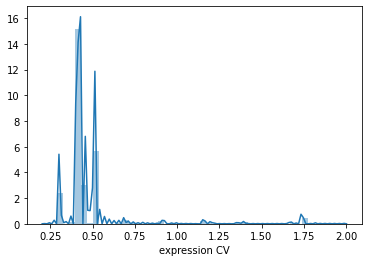

In [21]:
#plot all promoter distribution of TF CV values
all_prom_distribution(Czechowski_merged, 'expression_CV', 'expression CV', 'Czechowski_expressionCV')

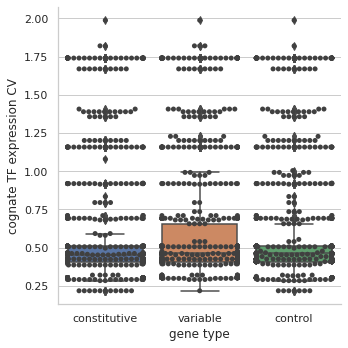

In [22]:
#plot the CV for each promoter gene_type - whole promoter individual TF CVs
make_plot(Czechowski_genetypes,'gene_type', 'expression_CV','gene type', 'cognate TF expression CV', 'Czechowski_CV', 'box')

## the CV values seem to mainly have low CVs so tend towards constitutive as in Czechowski et al 2005

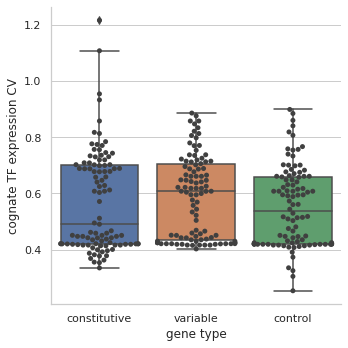

In [23]:
#plot the mean CV for each promoter gene_type - whole promoter mean TF CVs
make_plot(Czechowski_means_sd_genetype,'gene_type', 'mean_cv','gene type', 'cognate TF expression CV', 'Czechowski_CV_mean', 'box')

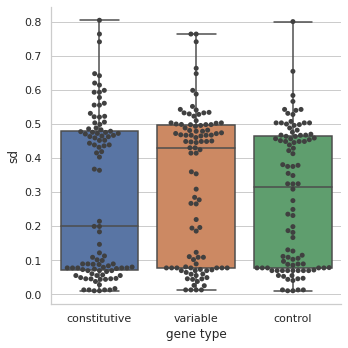

In [24]:
#plot the standard deviation of the CVs of the TFs binding each promoter split into gene_type
make_plot(Czechowski_means_sd_genetype,'gene_type', 'sd','gene type', 'sd', 'Czechowski_CV_sd', 'box')

In [25]:
# #now plot CV distribution for constitutive genes vs variable genes
#this took too long so commenting out for now
# make_plot(Czechowski_genetypes,'gene_type', 'expression_CV','gene type', 'expression CV', 'Czechowski_CV', 'box')

In [26]:
def test_normality(df,dependent_variable, between):
    """test normality of data categories"""
    #find gene_type categories
    pd.Categorical(df[between])
    names = df[between].unique()
    #Test normality
    #returns test statistic, p-value
    for name in names:
        print('{}: {}'.format(name, stats.shapiro(df[dependent_variable][df[between] == name])))

In [27]:
def describe_stats(df,dependent_variable, between):
    """return descriptve statistics"""
    return df.groupby([between])[dependent_variable].describe()

In [28]:
def variance(df, dependent_variable, between):
    """test variance of data categories"""
    #find gene_type categories
    pd.Categorical(df[between])
    names = df[between].unique()
    #test variance    
    return stats.levene(df[dependent_variable][df[between] == names[0]], 
               df[dependent_variable][df[between] == names[1]], 
               df[dependent_variable][df[between] == names[2]])

In [29]:
def kruskal_test(df,dependent_variable,between):
    """Do Kruskal-Wallis analysis"""
    #Kruskal-Wallis one way analysis of variance
    return kruskal(data=df, dv=dependent_variable, between=between)
    

In [30]:
def dunn_posthoc_test(df,dependent_variable, between):
    """dunn_posthoc tests with bonferroni multiple correction"""
    return sp.posthoc_dunn(df, val_col=dependent_variable, group_col=between, p_adjust='bonferroni')

In [31]:
#rename df for easier analysis
df = Czechowski_means_sd_genetype
between_variable = 'gene_type'
dependent_variable = 'mean_cv'

In [32]:
test_normality(df,dependent_variable,between_variable)

constitutive: ShapiroResult(statistic=0.8800174593925476, pvalue=1.8179507321747224e-07)
variable: ShapiroResult(statistic=0.9057092666625977, pvalue=2.6499919840716757e-06)
control: ShapiroResult(statistic=0.9448584318161011, pvalue=0.00038628641050308943)


## not normal

In [33]:
variance(df, dependent_variable,between_variable)

LeveneResult(statistic=3.240837400658055, pvalue=0.04051917700949841)

### fail to reject null hypothesis that variances are equal

In [34]:
#descriptive stats
describe_stats(df, dependent_variable,between_variable)

,count,mean,std,min,25%,50%,75%,max
gene_type,,,,,,,,
constitutive,100.0,0.570179,0.177617,0.335001,0.420389,0.492573,0.701826,1.215566
control,100.0,0.550783,0.142081,0.253779,0.420525,0.536689,0.659120,0.898453
variable,100.0,0.588441,0.143706,0.402585,0.435059,0.607536,0.702733,0.885548


In [35]:
kruskal_test(df, dependent_variable,between_variable)

,Source,ddof1,H,p-unc
Kruskal,gene_type,2,4.760128,0.092545


In [36]:
#not a significant difference in CV values between constitutive and variable or control 400bp promoters

In [37]:
# dunn_posthoc_test(df, dependent_variable,between_variable)

In [38]:
## test to see if difference in standard_deviation between CV values of TFs binding each promoter for each promoter gene type

In [39]:
#rename df for easier analysis
df = Czechowski_means_sd_genetype
between_variable = 'gene_type'
dependent_variable = 'sd'

In [40]:
>
/src/plotting/
Name
Last Modified

test_normality(df,dependent_variable,between_variable)

constitutive: ShapiroResult(statistic=nan, pvalue=1.0)
variable: ShapiroResult(statistic=nan, pvalue=1.0)
control: ShapiroResult(statistic=nan, pvalue=1.0)


In [41]:
#descriptive stats
describe_stats(df, dependent_variable,between_variable)

,count,mean,std,min,25%,50%,75%,max
gene_type,,,,,,,,
constitutive,99.0,0.286909,0.232492,0.009657,0.070408,0.198939,0.477951,0.804745
control,96.0,0.283805,0.201304,0.009657,0.076815,0.316045,0.464406,0.800745
variable,98.0,0.326868,0.216647,0.012227,0.076815,0.429849,0.497224,0.764199


In [42]:
kruskal_test(df, dependent_variable,between_variable)

,Source,ddof1,H,p-unc
Kruskal,gene_type,2,2.364924,0.306523


In [42]:
## no significant difference in TFBS CV sd between the promoter types